In [24]:
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq
import os
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.tools.retriever import create_retriever_tool
from langgraph.prebuilt import ToolNode
from typing import TypedDict, Annotated, Sequence, Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langchain.prompts import PromptTemplate

In [2]:
import os
## Langchain and Langsmith tracing
os.environ['LANGCHAIN_API_KEY'] = os.getenv('LANGCHAIN_API_KEY')
os.environ['LANGCHAIN_PROJECT'] = os.getenv('LANGCHAIN_PROJECT')
os.environ["LANGCHAIN_TRACING_V2"]="true"

## Getting Froq API key
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
INFERENCE_MODEL = "deepseek-r1-distill-llama-70b"

### Initializing LLM and Embeddings

In [3]:
llm = ChatGroq(model=INFERENCE_MODEL)

embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
len(embeddings.embed_query('Hi'))


e:\AgenticAI KrishNaikAcademy\Classroom HandsOn\agentic_class_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

### Creating the RAG

In [124]:
urls=[
    "https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/",
    "https://jalammar.github.io/illustrated-gpt2/",
    "https://jalammar.github.io/illustrated-word2vec/",
    "https://jalammar.github.io/illustrated-bert/",
    "https://jalammar.github.io/illustrated-transformer/"
]

In [125]:
docs = [WebBaseLoader(url).load() for url in urls]
docs

[[Document(metadata={'source': 'https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/', 'title': 'A Visual Guide to Using BERT for the First Time – Jay Alammar – Visualizing machine learning one concept at a time.', 'description': 'Translations: Chinese, Korean, Russian\n\n\n  \n  \n\n\nProgress has been rapidly accelerating in machine learning models that process language over the last couple of years. This progress has left the research lab and started powering some of the leading digital products. A great example of this is the recent announcement of how the BERT model is now a major force behind Google Search. Google believes this step (or progress in natural language understanding as applied in search) represents “the biggest leap forward in the past five years, and one of the biggest leaps forward in the history of Search”.\n\nThis post is a simple tutorial for how to use a variant of BERT to classify sentences. This is an example that is basic enough as a f

In [126]:
docs_list = [item for subitem in docs for item in subitem]
docs_list

[Document(metadata={'source': 'https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/', 'title': 'A Visual Guide to Using BERT for the First Time – Jay Alammar – Visualizing machine learning one concept at a time.', 'description': 'Translations: Chinese, Korean, Russian\n\n\n  \n  \n\n\nProgress has been rapidly accelerating in machine learning models that process language over the last couple of years. This progress has left the research lab and started powering some of the leading digital products. A great example of this is the recent announcement of how the BERT model is now a major force behind Google Search. Google believes this step (or progress in natural language understanding as applied in search) represents “the biggest leap forward in the past five years, and one of the biggest leaps forward in the history of Search”.\n\nThis post is a simple tutorial for how to use a variant of BERT to classify sentences. This is an example that is basic enough as a fi

In [131]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25,allowed_special={'<|endoftext|>'})

In [132]:
doc_splits=text_splitter.split_documents(docs_list)
doc_splits

[Document(metadata={'source': 'https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/', 'title': 'A Visual Guide to Using BERT for the First Time – Jay Alammar – Visualizing machine learning one concept at a time.', 'description': 'Translations: Chinese, Korean, Russian\n\n\n  \n  \n\n\nProgress has been rapidly accelerating in machine learning models that process language over the last couple of years. This progress has left the research lab and started powering some of the leading digital products. A great example of this is the recent announcement of how the BERT model is now a major force behind Google Search. Google believes this step (or progress in natural language understanding as applied in search) represents “the biggest leap forward in the past five years, and one of the biggest leaps forward in the history of Search”.\n\nThis post is a simple tutorial for how to use a variant of BERT to classify sentences. This is an example that is basic enough as a fi

#### Creating a single vector store for all the documents

In [133]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings
)

In [134]:
retriever = vectorstore.as_retriever()
retriever.invoke("How the Sentence Sentiment Classification is performed?")

[Document(metadata={'title': 'A Visual Guide to Using BERT for the First Time – Jay Alammar – Visualizing machine learning one concept at a time.', 'language': 'No language found.', 'source': 'https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/', 'description': 'Translations: Chinese, Korean, Russian\n\n\n  \n  \n\n\nProgress has been rapidly accelerating in machine learning models that process language over the last couple of years. This progress has left the research lab and started powering some of the leading digital products. A great example of this is the recent announcement of how the BERT model is now a major force behind Google Search. Google believes this step (or progress in natural language understanding as applied in search) represents “the biggest leap forward in the past five years, and one of the biggest leaps forward in the history of Search”.\n\nThis post is a simple tutorial for how to use a variant of BERT to classify sentences. This is an ex

### Create Retriever Tool

In [135]:
retriever_tools = create_retriever_tool(
    retriever,
    "Jalammar_Blog_Post",
    "Search and return information from Jalammar blog post"
)


### Create a Tool Node with the Retriever Tool

In [136]:
tools_list = [retriever_tools]
retriever_tool_node = ToolNode(tools_list)

In [137]:
retriever_tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'Jalammar_Blog_Post': Tool(name='Jalammar_Blog_Post', description='Search and return information from Jalammar blog post', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x000002E9EF0EF560>, retriever=VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000002E9A437B750>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x000002E9EF121080>, retriever=VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chr

### Bind the tools with the LLM

In [138]:
llm_with_tools = llm.bind_tools(tools_list)
response=llm_with_tools.invoke("How is the Sentence Sentiment Classification working under the hood?")
response.content

'Sure! Let me break down how sentence sentiment classification works under the hood.\n\n### 1. **Understanding the Task**\n   - **Objective**: Determine the sentiment (e.g., positive, negative, neutral) of a given sentence.\n   - **Example**: \n     - Input: "I loved the movie!"\n     - Output: Positive\n\n### 2. **Data Collection**\n   - **Datasets**: Use labeled datasets where each sentence is tagged with its sentiment (e.g., IMDB for movie reviews, Stanford Sentiment Treebank).\n   - **Preprocessing**: Clean the data by removing noise, handling out-of-vocabulary words, and normalizing text (e.g., lowercasing).\n\n### 3. **Text Preprocessing**\n   - **Tokenization**: Split sentences into words or tokens.\n   - **Stopword Removal**: Remove common words like "the," "and" that don\'t add much value.\n   - **Stemming/Lemmatization**: Reduce words to their base form (e.g., "loving" becomes "love").\n   - **Vectorization**: Convert text into numerical representations (e.g., word embeddings

In [139]:
response.tool_calls


[]

### Create the nodes of the Graph

In [63]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Create LLM Decision Maker

In [64]:
def LLM_Decision_Maker(state:AgentState):
    message = state["messages"]
    last_message = message[-1]
    question = last_message.content
    response = llm_with_tools.invoke(question)
    return {"messages":[response]}
    

### Create the Document Grading Node

In [171]:
class grade(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score:str=Field(description="Documents are relevant: 'yes' or 'no'")


In [170]:
def grade_documents(state:AgentState)->Literal["Output Generator","Query Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structured_op = llm.with_structured_output(grade)
    prompt=PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
                    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
                    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
                    Here is the document: {context}
                    Here is the user’s question: {question}""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structured_op
    message = state["messages"]
    last_message = message[-1]
    question = message[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question":question, "context":docs})
    score = scored_result.binary_score

    if score == "yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [67]:
from langchain import hub
hub.pull("rlm/rag-document-relevance").pretty_print()

================================ System Message ================================

You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n

It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n

Give a binary score 1 or 0 score, where 1 means that the document is relevant to the question.

================================ Human Message =================================

Retrieved documents:  

User question: 


In [68]:
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


### Create the output generation node

In [172]:
def output_generation(state:AgentState):
    print("----RAG OUTPUT GENERATE----")

    # print(f"State in o/p gen is: {state}")
    
    message = state["messages"]
    question = message[0].content

    last_message = message[-1]
    docs = last_message.content

    prompt=hub.pull("rlm/rag-prompt")

    rag_chain=prompt | llm

    response=rag_chain.invoke({"context": docs, "question": question})

    print(f"this is my response:{response}")

    return {"messages": [response]}

### Create the Query Rewrite Node

In [173]:
def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    message = state["messages"]
    question = message[0].content
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    response=llm.invoke(input)
    print(f"Transformed Query is: {response}")
    
    return {"messages": [response]}

### Create the Web Searcher Node

In [174]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [175]:
from langchain.schema import Document

def web_retriever(query):
    # query = inputs["question"]
    result = web_search_tool.invoke({"query": query})
    web_results = "\n".join([d["content"] for d in result])
    # print(web_results)
    web_results = Document(page_content=web_results)
    print(web_results)
    # snippets = [r["content"] for r in result["results"] if "content" in r]
    # # return "\n\n".join(snippets)
    # return {"context": "\n\n".join(snippets), "question": query}

In [176]:
import pprint
# web_retriever("What is the capital of Australia?")


In [177]:
def web_search(state:AgentState):
    print("----Searching Web for requisite context----")
    # print(f"State in web_search: {state}")
    message = state["messages"]
    question = message[0].content

    last_message = message[-1]
    docs = last_message.content

    # print(f"docs before web_search:{docs}")

    web_docs = web_search_tool.invoke({"query":question})
    web_results = "\n".join([d["content"] for d in web_docs])
    # print(f"Web Search Results are: {web_results}")
    # web_results = Document(page_content=web_results)
    docs = docs + "\n" + web_results
    # print(f"docs after web_search:{docs}")
    # return "\n\n".join(snippets)
    return {"messages": [response]}
    

### Build the workflow

In [178]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import tools_condition

workflow = StateGraph(AgentState)
workflow.add_node("LLM Decision Maker", LLM_Decision_Maker)
workflow.add_node("Vector Retriever", retriever_tool_node)
workflow.add_node("Output Generator", output_generation)
workflow.add_node("Query Rewriter", rewrite)
workflow.add_node("Web Search", web_search)

workflow.add_edge(START, "LLM Decision Maker")
workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {
                                   "tools":"Vector Retriever",
                                   END:END
                               })
workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {
                                   "generator":"Output Generator",
                                   "rewriter":"Query Rewriter"
                               })
workflow.add_edge("Query Rewriter","Web Search")
workflow.add_edge("Web Search","Output Generator")
workflow.add_edge("Output Generator",END)

CRAG = workflow.compile()




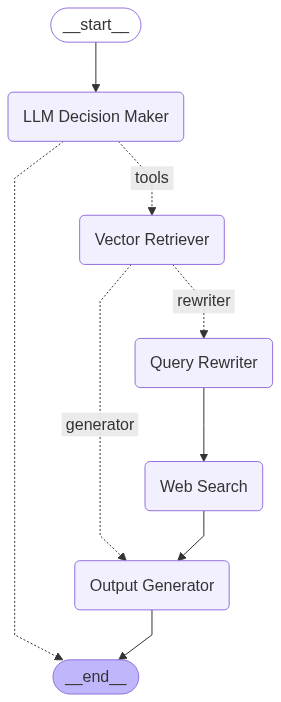

In [179]:
from IPython.display import Image, display
display(Image(CRAG.get_graph().draw_mermaid_png()))

In [183]:
# CRAG.invoke({"messages":["What are the types of agent memory?"]})
for output in CRAG.stream({"messages":["What are the types of agent memory?"]}):
    print(output)

{'LLM Decision Maker': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5r65jn2ht', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'Jalammar_Blog_Post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 648, 'prompt_tokens': 149, 'total_tokens': 797, 'completion_time': 2.993420117, 'prompt_time': 0.01057799, 'queue_time': 0.05776752499999999, 'total_time': 3.003998107}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2af0cba8-530d-400c-907c-4d84bd698656-0', tool_calls=[{'name': 'Jalammar_Blog_Post', 'args': {'query': 'types of agent memory'}, 'id': '5r65jn2ht', 'type': 'tool_call'}], usage_metadata={'input_tokens': 149, 'output_tokens': 648, 'total_tokens': 797})]}}
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE NOT RELEVANT----
{'Vector Retriever': {'messages': [ToolMessage(content='Thes